# Dask DataFrame

Материалы: 
* Макрушин С.В. Лекция 13: Dask DataFrame
* https://docs.dask.org/en/latest/dataframe.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

In [1]:
import json
import re
from pathlib import Path

import dask.bag as db
import dask.dataframe as dd
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = Path('data/')
OUTPUT_DIR = Path('output/')
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir()

## Задачи для совместного разбора

1. Считать данные из файлов в каталоге `accounts`. Содержат ли какие-либо из столбцов пропуски?

In [3]:
accounts_df: dd.DataFrame = dd.read_csv(
    DATA_DIR.joinpath('accounts/accounts.*.csv'),
    sep=',',
    dtype={'id': np.uint16, 'names': object, 'amount': np.float32}
).persist()
accounts_df.head(5)

,id,names,amount
0,39,Victor,205.0
1,289,Hannah,87.0
2,234,Victor,1820.0
3,155,Ray,-600.0
4,266,Ray,572.0


In [4]:
accounts_df.isna().sum().compute()

id        0
names     0
amount    3
dtype: int64

2. Подсчитать количество раз, которое то или иное имя встретилось в выборке. Вывести самое часто встречающееся имя.

In [5]:
name_freq: pd.Series = accounts_df['names'].value_counts().compute()

In [6]:
print(name_freq.head(1))
name_freq

Norbert    188147
Name: names, dtype: int64


Norbert     188147
Alice       185892
George      183249
Tim         162432
Bob         157065
Michael     148372
Ingrid      132067
Oliver      121907
Quinn       118071
Wendy       110657
Charlie     109236
Ursula      108745
Hannah      108632
Ray         108610
Sarah       104781
Victor      102656
Frank        99984
Laura        97216
Jerry        96378
Xavier       94445
Edith        89991
Zelda        89047
Kevin        84784
Dan          73293
Patricia     62881
Yvonne       61462
Name: names, dtype: int64

3. Создать новую колонку, которая является результатом от деления значения `amount` нацело на 100, если `amount` > 100, и нулём в противном случае.

In [7]:
accounts_df['new_amount'] = accounts_df['amount'].map(lambda x: x // 100 if x > 100 else 0)

In [8]:
accounts_df.compute().sample(10).head(30)

,id,names,amount,new_amount
914209,235,Jerry,1735.0,17.0
326347,35,Alice,262.0,2.0
664822,278,Alice,567.0,5.0
997106,14,Alice,301.0,3.0
650116,94,Victor,-202.0,0.0
678475,141,Patricia,252.0,2.0
154906,301,Oliver,106.0,1.0
423577,408,Frank,-364.0,0.0
220978,304,Sarah,2676.0,26.0
750674,465,Edith,27.0,0.0


In [9]:
del accounts_df

## Лабораторная работа 13

1. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты.

In [10]:
recipes_df: dd.DataFrame = dd.read_csv(
    DATA_DIR.joinpath('recipes_full/recipes_full_*.csv'),
    sep=',',
    parse_dates=['submitted'],
    dtype={
        'id': np.uint32,
        'name': object,
        'minutes': np.float32,
        'contributor_id': np.uint32,
        'n_steps': np.float32,
        'description': object,
        'n_ingredients': np.uint32,
    }
)

2. Выведите метаинформацию о таблице: `npartitions` и типы столбцов.

In [11]:
print(recipes_df.npartitions)
print(recipes_df.dtypes)

16
id                        uint32
name                      object
minutes                  float32
contributor_id            uint32
submitted         datetime64[ns]
n_steps                  float32
description               object
n_ingredients             uint32
dtype: object


3. Выведите на экран 5 первых строк таблицы. Выведите на экран 5 последних строк таблицы. В случае сообщения об ошибки объясните причину и исправьте ошибку.

In [12]:
recipes_df.head()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970,vant ivoire mickies nothing,33.0,803776,2019-08-22,4.0,pat and gina neely and their family own and op...,9
1,1089012,kremsils mariposa baccala cookies class borage...,23.0,51579,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5
2,1428572,tania lander,0.0,68884,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5
3,1400250,heloise milli asher doogh zojirushi,24.0,678862,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1
4,387709,nutty chocolate chunk cookies,47.0,489552,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10


In [13]:
recipes_df.tail()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
44011,1029131,tuti waffle snackies steakhouse,19.0,171345,1973-10-18,4.0,"according to a providence journal article, ama...",4
44012,1700703,noelias cheats crocante fleisch zitumbuwa,1.0,30228,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1
44013,1910650,rubbed restuffed pelmeni bedouin flavourful,60.0,591905,2009-09-26,3.0,another great recipe to add to the growing swe...,2
44014,713836,stems polpettine peezi,NaN,357389,2003-09-30,4.0,adapted from top secret recipes. love this!,9
44015,660699,clementines,64.0,29196,1973-06-03,6.0,this would make a great start to your holiday ...,8


4. Посчитайте, сколько строк содержит каждый из блоков

In [14]:
recipes_df['id'].map_partitions(lambda partition: partition.count()).compute()

0     237505
1      41450
2     235222
3      43733
4     238139
5      40816
6     234750
7      44205
8     237887
9      41068
10    234486
11     44468
12    238298
13     40656
14    234938
15     44016
dtype: int64

5. Найдите максимум в столбце `n_steps`. Визуализируйте граф вычислений для этой задачи. Прокомментируйте логику работы `dask` в этом случае.

In [15]:
n_steps_max = recipes_df['n_steps'].max()

In [16]:
n_steps_max.compute()

145.0

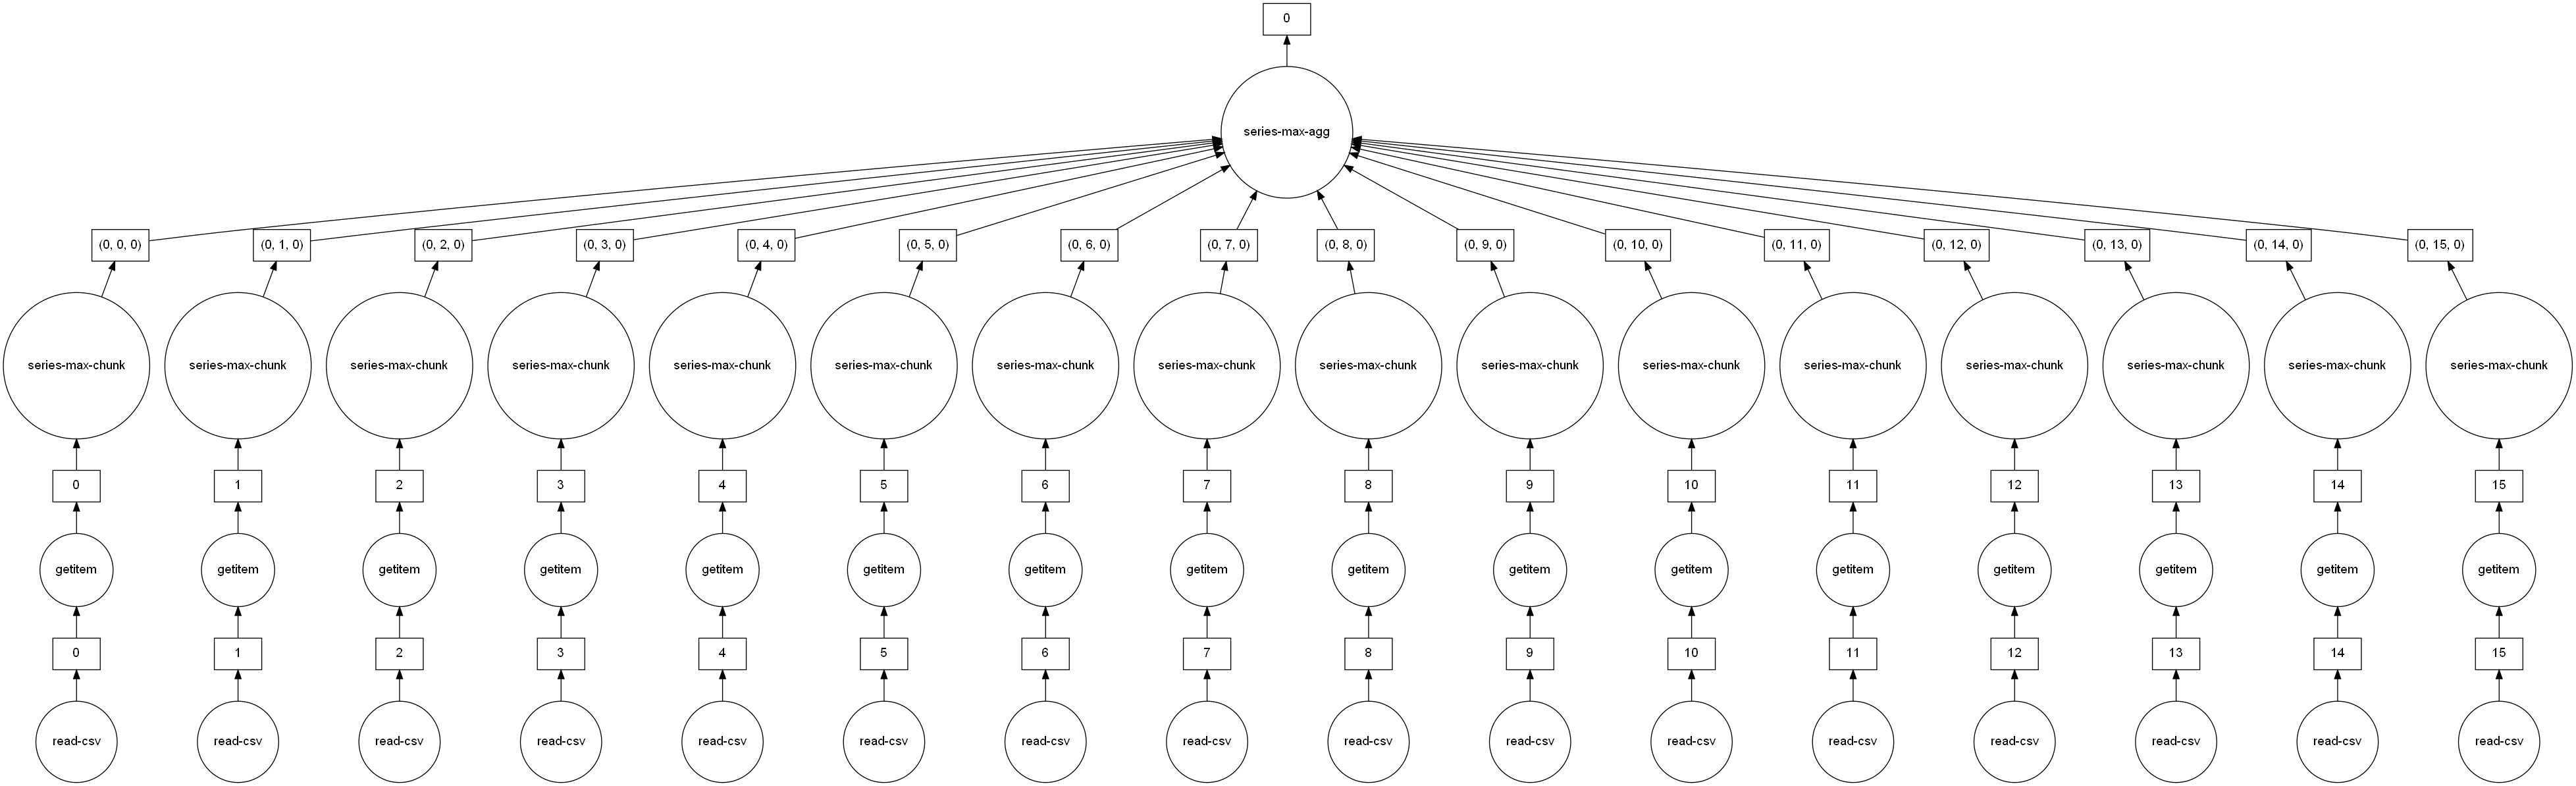

In [17]:
n_steps_max.visualize(filename=str(OUTPUT_DIR.joinpath('n_steps_max.png')))

6. Посчитайте количество отзывов с группировкой по месяцам добавления отзыва в базу.

In [18]:
submitted = recipes_df['submitted']
count = submitted.groupby(submitted.dt.month).count()

In [19]:
%%time

recipes_count = count.compute()

Wall time: 8.52 s


In [20]:
recipes_count

submitted
1     193363
2     173834
3     192389
4     186049
5     192487
6     184205
7     189337
8     187276
9     181081
10    187018
11    180974
12    183624
Name: submitted, dtype: int64

7. Считайте файлы из архива `reviews_full.zip` (__ЛР12__) в виде `dask.bag`. Пользуясь результатом лабораторной работы 12, рассчитайте среднее значение оценок отзывов с группировкой по месяцам. После завершения всех вычислений преобразуйте результат к `pd.Series`.

In [21]:
pattern = re.compile(r'^.*reviews_(\d+)\.json$')


def loads(element: tuple[str, str]) -> dict:
    data, path = element
    return {
        'month': int(json.loads(data)['date'][5:7]),
        'rating': int(pattern.match(path).groups()[0])
    }


reviews_bag = db.read_text(
    DATA_DIR.joinpath('reviews_full/*.json'),
    include_path=True,
    blocksize=30_000_000,
).map(loads)

reviews_bag.take(3)

({'month': 5, 'rating': 0},
 {'month': 6, 'rating': 0},
 {'month': 11, 'rating': 0})

In [22]:
mean = reviews_bag.foldby(
    lambda x: x['month'],
    lambda prev, curr: (prev[0] + 1, prev[1] + curr['rating']),
    (0, 0),
    lambda left, right: (left[0] + right[0], left[1] + right[1]),
    (0, 0)
)

In [23]:
%%time

mean_result = mean.compute()

Wall time: 31 s


In [24]:
mean_rating = pd.Series(
    map(lambda x: x[1][1] / x[1][0], mean_result),
    map(lambda x: int(x[0]), mean_result)
)
mean_rating

5     4.415401
6     4.418419
11    4.408829
9     4.410661
10    4.411452
4     4.412259
2     4.407135
3     4.406911
12    4.406908
1     4.408553
7     4.411717
8     4.410822
dtype: float64

8. Пользуясь результатами решения задач 6 и 7, создайте `pd.DataFrame`, содержащий два столбца: `mean_rating`, `recipes_count`

In [25]:
pd.concat([
    mean_rating.rename('mean_rating'),
    recipes_count.rename('recipes_count')
], axis=1).sort_index()

,mean_rating,recipes_count
1,4.408553,193363
2,4.407135,173834
3,4.406911,192389
4,4.412259,186049
5,4.415401,192487
6,4.418419,184205
7,4.411717,189337
8,4.410822,187276
9,4.410661,181081
10,4.411452,187018
